<a href="https://colab.research.google.com/github/pavankalyan25853/pavankalyan25853/blob/main/Restaurant_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go

In [ ]:
# Importing libraries for performing Natural Language Processing on 'Restaurant_Reviews.tsv' dataset
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t', quoting=3)

In [ ]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
df.shape

(1000, 2)

In [ ]:
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [ ]:
#EXPLORATORY DATA ANALYSIS
Labels = pd.DataFrame(df['Liked'].value_counts()).reset_index()
Labels.columns = ['Liked','Count']
Labels['Liked'] = Labels['Liked'].map({0: 'Negative',1: 'Positive'})

fig = px.pie(Labels, values = 'Count', names = 'Liked', title='Percentage of reviews', hole=.4, color = 'Liked',
             width=800, height=400)
fig.show()

In [ ]:
positive_reviews = df[df["Liked"] == 1]

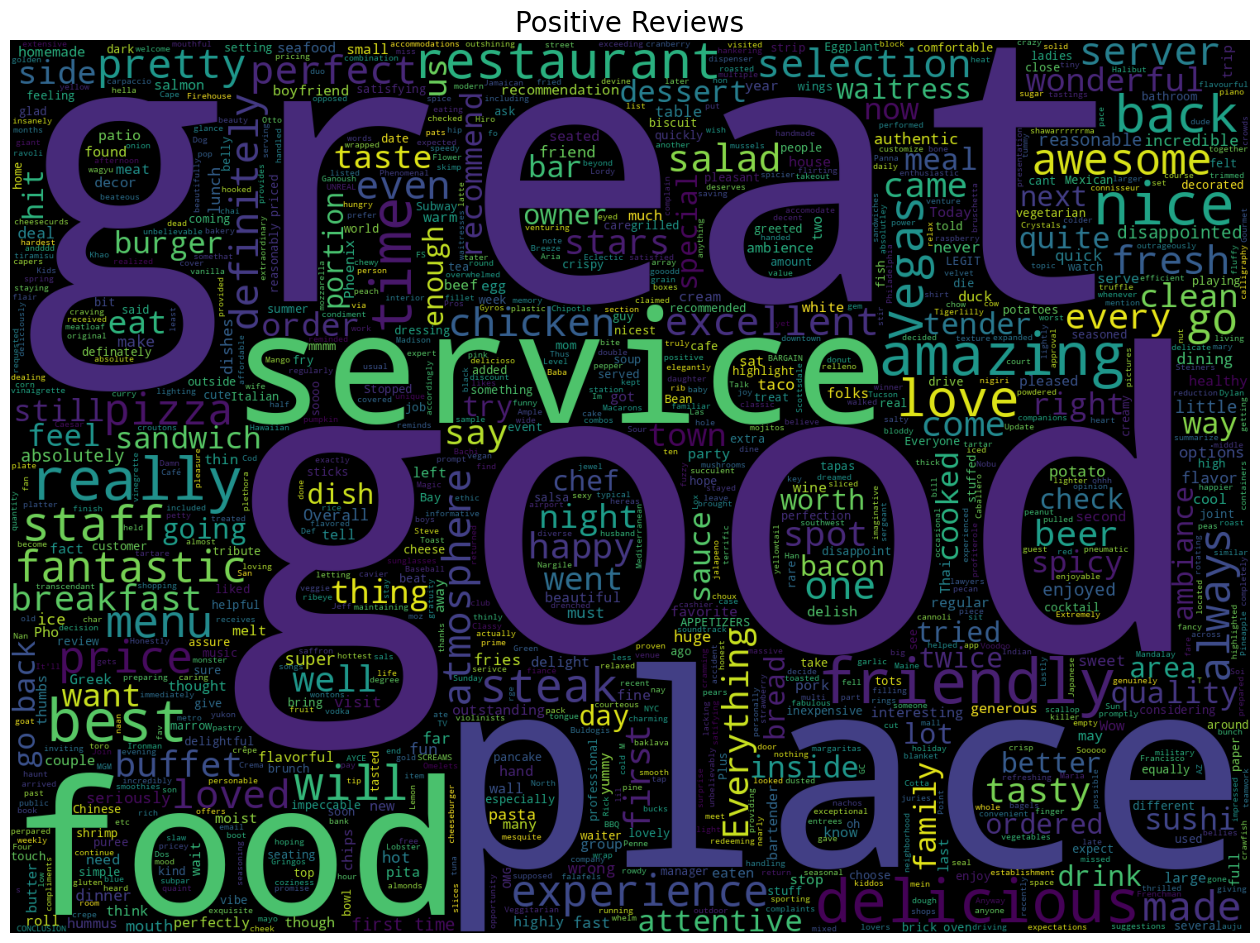

In [ ]:
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='black',max_words = 10000,
                          width=1500, stopwords=STOPWORDS,
                          height=1080
                         ).generate(" ".join(positive_reviews.Review))
plt.title("Positive Reviews", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()


In [ ]:
negative_reviews = df[df["Liked"] == 0]

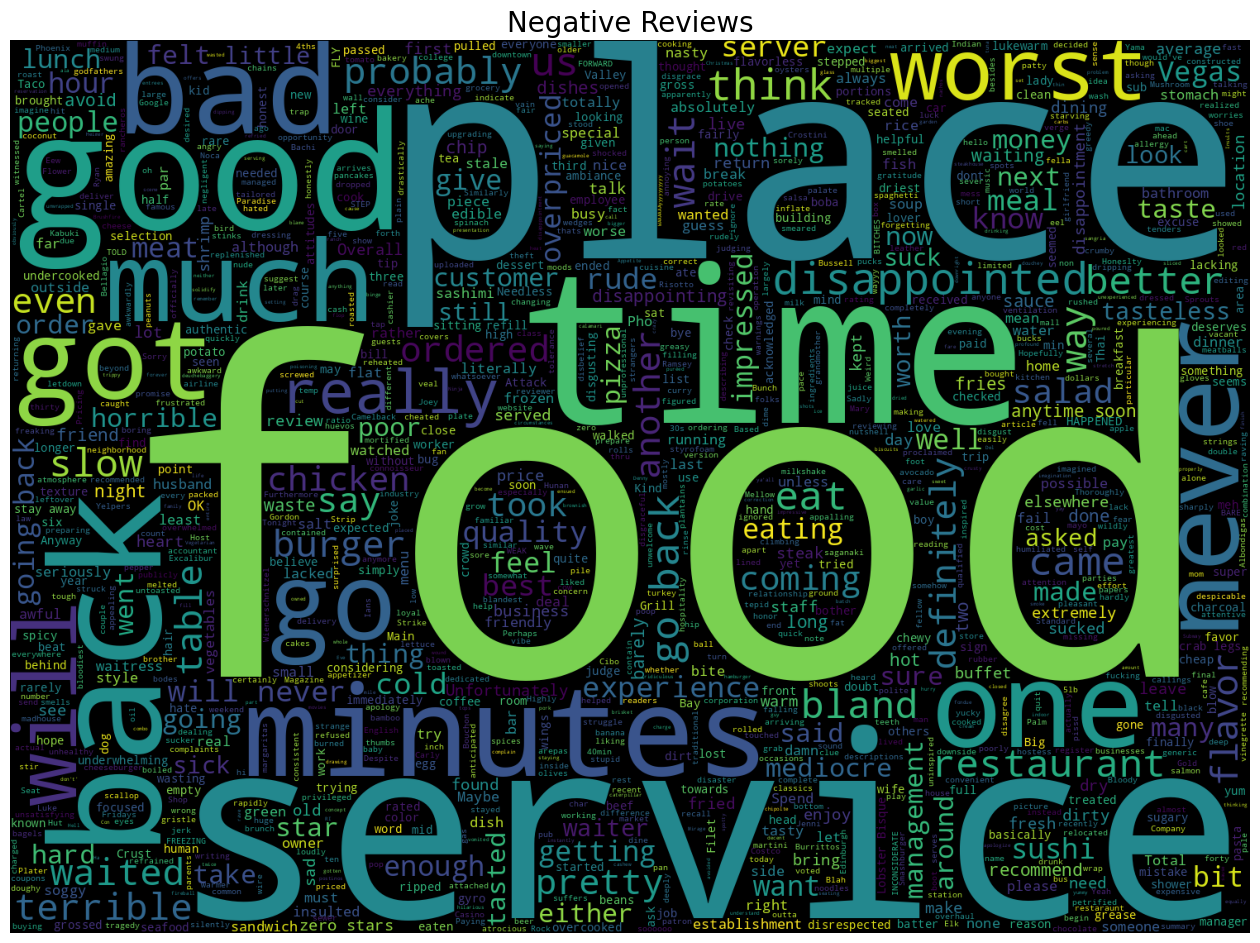

In [ ]:
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='black',max_words = 10000,
                          width=1500, stopwords=STOPWORDS,
                          height=1080
                         ).generate(" ".join(negative_reviews.Review))
plt.title("Negative Reviews", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

In [ ]:
# Here we get the length of each review
df['Length']= df['Review'].apply(len)
df.head()

,Review,Liked,Length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


In [ ]:
corpus = []
for i in range(0,len(df)):
  review = re.sub(pattern='[^a-zA-Z]',repl=' ', string=df['Review'][i])
  review = review.lower()
  review_words = review.split()
  review_words = [word for word in review_words if not word in set(stopwords.words('english'))]
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review_words]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
corpus[0:5]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

In [ ]:
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.loc[:, 'Liked'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [ ]:
def Model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model,accuracy

In [ ]:
result = pd.DataFrame(columns = ["Model", "Accuracy"])

models = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(n_estimators=1000),
                      KNeighborsClassifier(n_neighbors = 7, metric = "minkowski", p = 2),
                      SVC(kernel = 'rbf'), GaussianNB(), XGBClassifier(n_estimators=300, learning_rate=0.01)]

for model in models:
    clf, accuracy = Model(model)
    result = result.append({"Model": model, "Accuracy": accuracy}, ignore_index=True)

result

,Model,Accuracy
0,DecisionTreeClassifier(),0.640
1,LogisticRegression(),0.765
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.690
3,KNeighborsClassifier(n_neighbors=7),0.650
4,SVC(),0.765
5,GaussianNB(),0.690
6,"XGBClassifier(base_score=None, booster=None, c...",0.745


In [ ]:
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = classifier.predict(X_test)

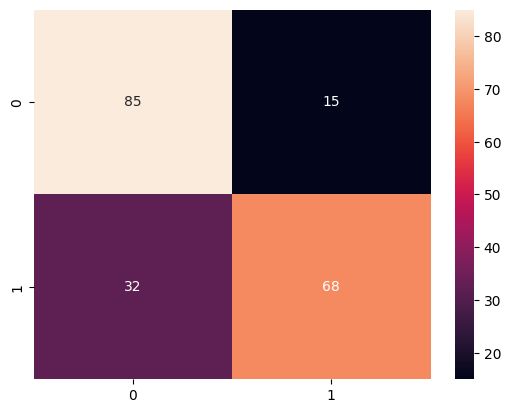

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)
plt.show()

In [ ]:
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [ ]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.1)


In [ ]:
print(grid.best_score_)

0.7737499999999999


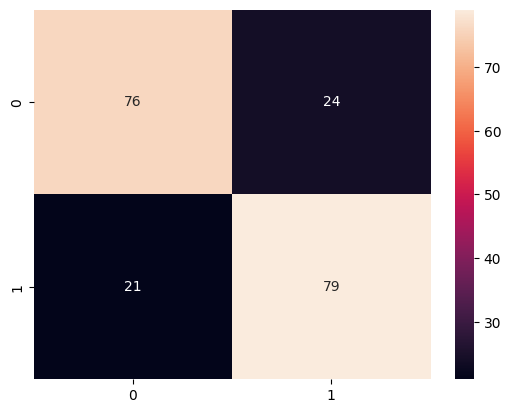

In [ ]:
pred = grid.predict(X_test)
# Making the Confusion Matrix
cm1 = confusion_matrix(y_test, pred)
sns.heatmap(cm1,annot=True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
score1 = accuracy_score(y_test,y_pred)
score2 = precision_score(y_test,y_pred)
score3= recall_score(y_test,y_pred)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))



Accuracy is  76.5 %
Precision is  0.82
Recall is  0.68


In [ ]:
def predict_sentiment(sample_review):
    sample_review = re.sub(pattern='[^a-zA-Z]',repl=' ', string = sample_review)
    sample_review = sample_review.lower()
    sample_review_words = sample_review.split()
    sample_review_words = [word for word in sample_review_words if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    final_review = [ps.stem(word) for word in sample_review_words]
    final_review = ' '.join(final_review)

    temp = cv.transform([final_review]).toarray()
    return grid.predict(temp)

In [ ]:
sample_review = 'The food is really good here.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [ ]:
sample_review = 'Food was pretty bad and the service was very slow.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a NEGATIVE review!


In [ ]:
# Predicting values
sample_review = 'The food was absolutely wonderful, from preparation to presentation, very pleasing.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [ ]:
# Predicting values
sample_review = 'The food was disastrous.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a NEGATIVE review!
